# SDSS Image Classification - Banded




## Data

This analysis will be making use of image "chips," fragments of images containing only the relevant object of interest. Due to the variable size of these objects (e.g. objects closer to the Earth appear bigger), each image is clipped using a 2-dimensional Gaussian, clipped at $3 \sigma$. This will *usually* prevent other objects from appearing in the image chip, however some objects are so closely spaced together (or sparsely distrubted) that there may be evidence of other objects in some of the image chips.

This notebook will all available bands of data, even if the object does not show up in a given band. This might provide more information for the network to learn off of, if some objects are visible in some wavelengths and not others.

In [1]:
# install things we might need 
!pip install "photutils[all]"
!pip install astropy
!pip install --pre astroquery
!pip install -q -U keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 855.2/855.2 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.1/353.1 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 49.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 25.1 MB/s eta 0:00:00
  Created wheel for asdf-wcs-schemas: filename=asdf_wcs_schemas-0.1.1-py3-none-any.whl size=26602 sha256=3bb906043ac2b

In [2]:

from pathlib import Path
import pickle


from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, smart_resize
import pandas as pd
import numpy as np
from keras import models
import keras_tuner as kt

np.random.seed(42)
tf.random.set_seed(42)

# plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# stats stuff
from astropy.stats import sigma_clip
import photutils
from astroquery.sdss import SDSS




In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# data_dir = Path("/content/drive/MyDrive/MIDS/207/SDSS-Classification/data/64x64_ugriz")
data_dir = Path("/content/drive/MyDrive/MIDS/207/SDSS-Classification/data/")
# img_dir = data_dir / "64x64_ugriz_50000"
img_dir = data_dir / "64x64_ugriz_74000"
# img_dir = data_dir / "64x64"
output_imgs_dir = data_dir.parent / "media"
# img_dir = data_dir / "64x64_riz"
# img_dir = data_dir / "128x128_ugriz"


In [5]:
# load in the image data (not needed for training!)

print(img_dir.exists())
if Path(img_dir / "imgs.pkl").exists():
    print(f"Found pickled images, loading from pickle...")
    with open(img_dir / "imgs.pkl", "rb") as f:
        imgs = pickle.load(f)

else:
  print(f"Cant find imgs. Does the pickle exist at {data_dir}?")




True
Found pickled images, loading from pickle...


In [6]:
imgs.shape

(74000, 64, 64, 5)

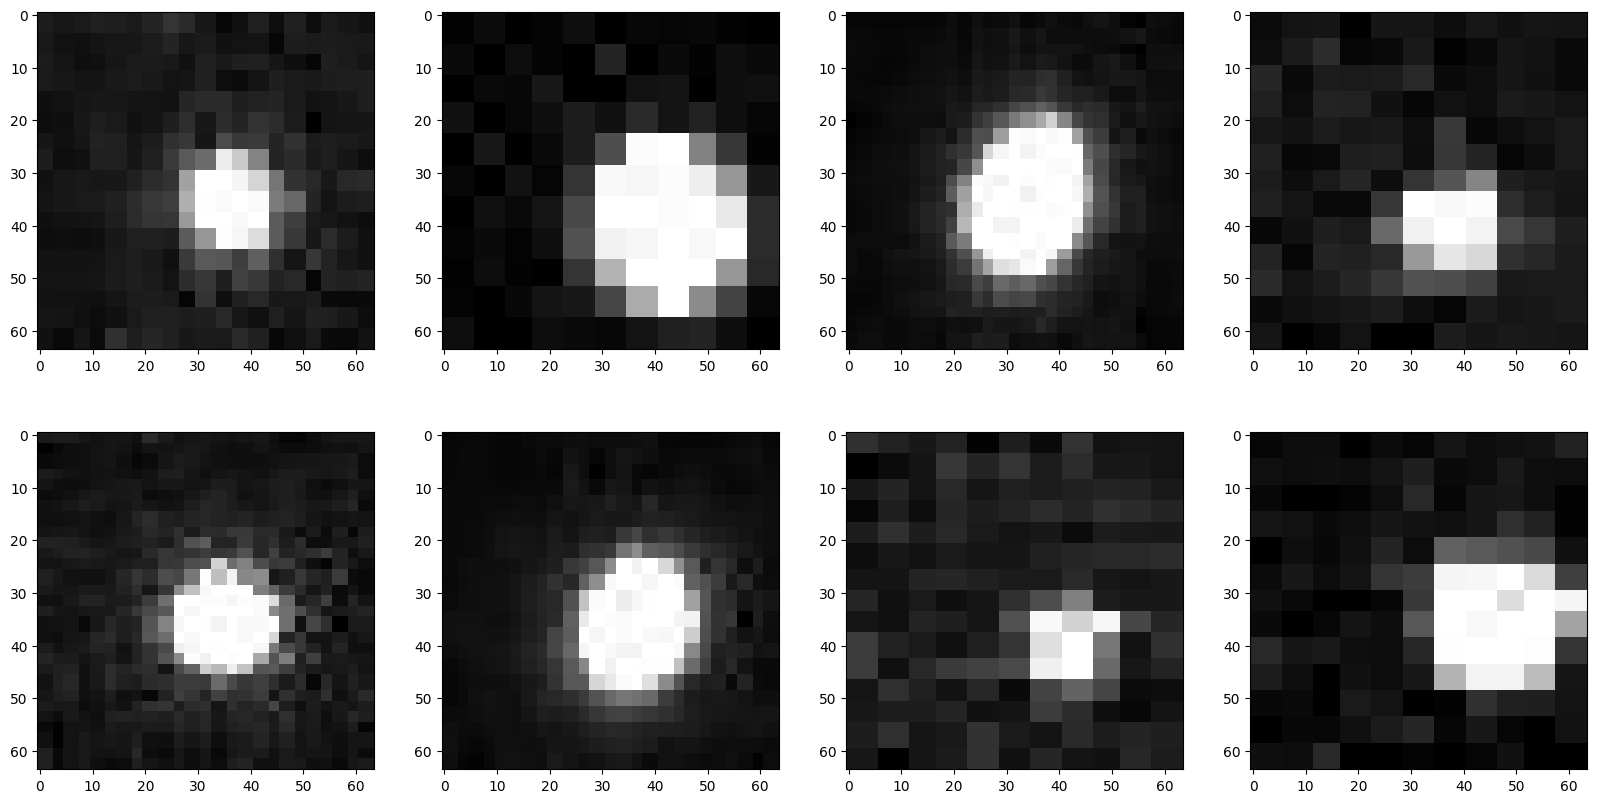

In [7]:
import matplotlib.pyplot as plt
nrows = 2
ncols = 4

n_bands = imgs.shape[3]
rand_idxs = np.random.randint(0, len(imgs), 8)
rand_band = np.random.randint(0, n_bands, 8)
plot_imgs = imgs[rand_idxs]

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

for i in range(nrows):
  for j in range(ncols):
    
    plot_idx = i*ncols + j
    band_idx = rand_band[i*ncols + j]
    ax[i, j].imshow(plot_imgs[plot_idx,:,:, band_idx], cmap='gray')
    


## Data Processing

Due to the asymetrical nature of the data (reference the label distributions in the EDA.ipynb), we will be randomly throwing out some of our images in order to train our models on a more evenly distributed data set. 

We won't do that here (since we already did it in `SDSS Image Classification - Preprocessing.ipynb`) 

We just load the pickled objects (if available)


In [8]:
bands = ['u', 'g', 'r', 'i', 'z']


In [9]:
def calc_noise(img_data):
  clipped = sigma_clip(img_data, sigma=3 )
  sigma = np.std(clipped)
  return (sigma)


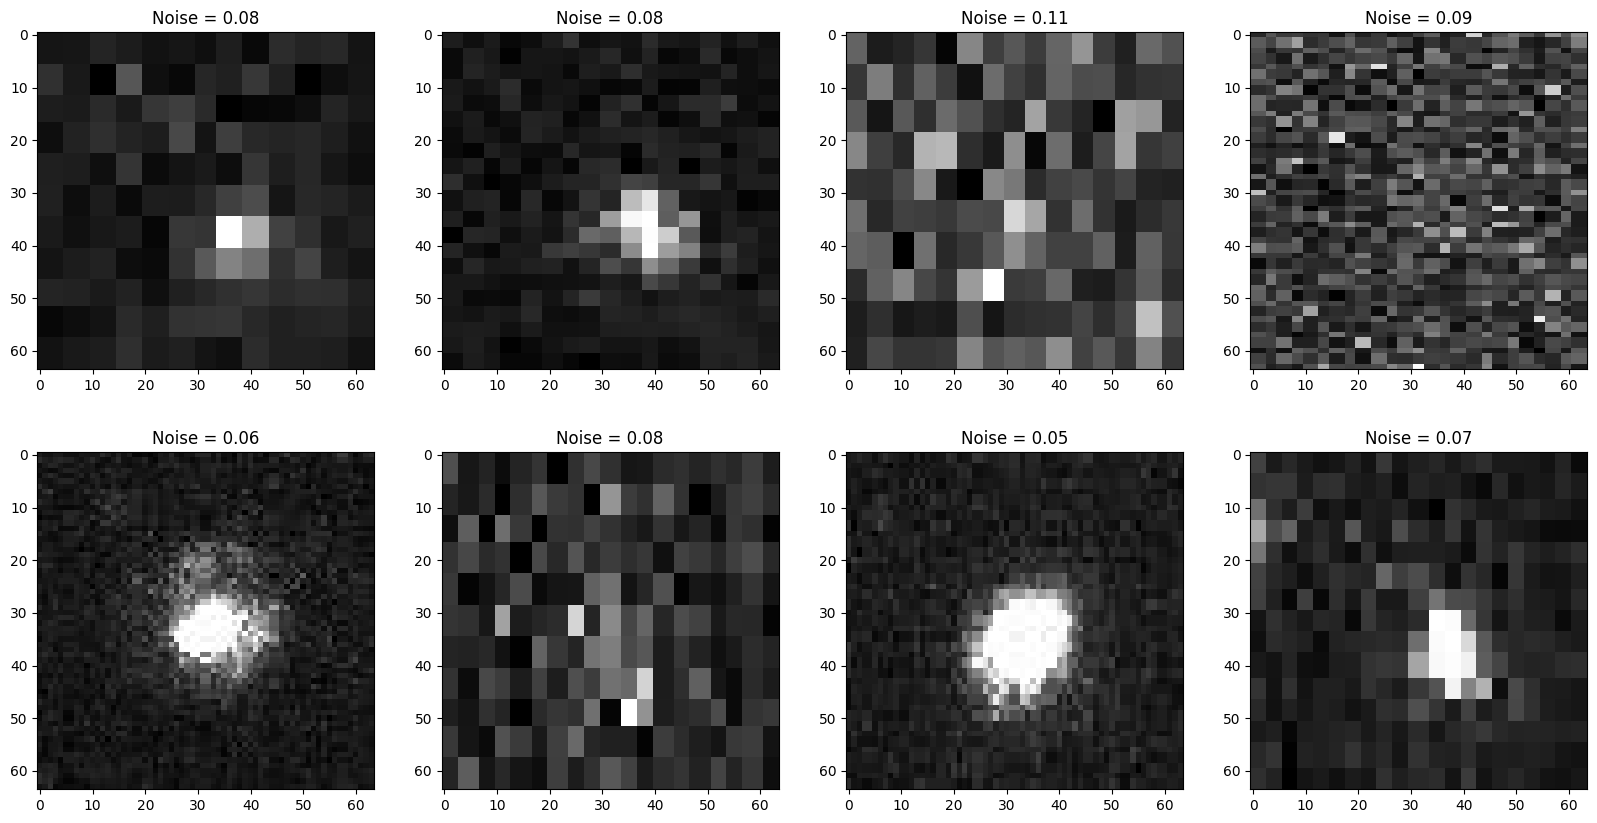

In [10]:
import matplotlib.pyplot as plt
nrows = 2
ncols = 4

rand_idxs = np.random.randint(0, len(imgs), 8)
rand_band = np.random.randint(0, 5, 8)
plot_imgs = imgs[rand_idxs]
snr_titles= [f"Noise = {calc_noise(img):.2f}" for img in plot_imgs]

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

for i in range(nrows):
  for j in range(ncols):
    
    plot_idx = i*ncols + j
    band_idx = rand_band[i*ncols + j]
    ax[i, j].imshow(plot_imgs[plot_idx,:,:, band_idx], cmap='gray')
    ax[i,j].set_title(f"{snr_titles[plot_idx]}")

In [11]:
bands = ["u", "g", "r", "i", "z"]

# load in the labels
df = pd.read_csv(data_dir / "star_classification.csv")

# we are only using the first 50,000 objects
df = df.iloc[:74000]
df.head()
obj_dist = (df.groupby("class").count()/len(df))['obj_ID']*100
obj_dist

class
GALAXY    59.432432
QSO       18.985135
STAR      21.582432
Name: obj_ID, dtype: float64

In [12]:
# encode labels
le = LabelEncoder()
le.fit(df["class"])
df['class'] = le.transform(df["class"])
ref_list = ["GALAXY", "QSO", "STAR"]
print(ref_list)
trans_ref_list = le.transform(ref_list)
print(trans_ref_list)

['GALAXY', 'QSO', 'STAR']
[0 1 2]


In [13]:
GALAXY = le.transform(["GALAXY"])[0]
QSO = le.transform(["QSO"])[0]
STAR = le.transform(["STAR"])[0]
# randomly throw out some samples so we have an balanced distribtuion.
n_samples = len(df[df['class'] == QSO]) # QSO has the smallest number of samples.

qso_idxs = df[df['class'] == QSO].index

galaxy_idxs = np.random.choice(
    df[df['class'] == GALAXY].index, 
    n_samples, 
    replace=False)

star_idxs = np.random.choice(
    df[df['class'] == STAR].index, 
    n_samples, 
    replace=False)


balanced_idxs = np.concatenate([qso_idxs, galaxy_idxs, star_idxs])

balanced_df = df.iloc[balanced_idxs]


balanced_obj_dist = (balanced_df.groupby("class").count()/len(balanced_df))['obj_ID']*100




# now balance the actual images
balanced_imgs = imgs[balanced_idxs, :, :, :]
print(balanced_obj_dist)
print(balanced_imgs.shape)

class
0    33.333333
1    33.333333
2    33.333333
Name: obj_ID, dtype: float64
(42147, 64, 64, 5)


In [14]:
# lets do some image transformations so we can have more robust training data
CONTRAST_FACTOR = 0.3
BRIGHTNESS_FACTOR = 0.3
FLIP = True 


def preprocess_images(images, df, split=[0.6, 0.2, 0.2], brightness_factor=BRIGHTNESS_FACTOR, contrast_factor=CONTRAST_FACTOR, flip=FLIP):
    print("Preprocessing images...")
    shuffle = np.random.permutation(len(images))
    images, y = images[shuffle], df['class'].values[shuffle]

    splits = np.multiply(len(images),split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    print("Starting with {} training samples, {} validation samples, and {} test samples".format(len(X_train), len(X_val), len(X_test)))

    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=BRIGHTNESS_FACTOR)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=contrast_factor)

    # random flip
    if flip:
        X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

        # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    print("Finishing with {} training samples, {} validation samples, and {} test samples".format(len(X_train), len(X_val), len(X_test)))
    return X_train, y_train, X_val, y_val, X_test, y_test

    

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_images(balanced_imgs, balanced_df)

Preprocessing images...
Starting with 25288 training samples, 8429 validation samples, and 8430 test samples
Finishing with 50576 training samples, 8429 validation samples, and 8430 test samples


In [16]:
img_dir

PosixPath('/content/drive/MyDrive/MIDS/207/SDSS-Classification/data/64x64_ugriz_74000')

In [17]:
WRITE = False
READ = False
if READ:
  with open(img_dir / "X_train.pkl", "rb") as f:
      X_train = pickle.load(f)

  with open(img_dir / "y_train.pkl", "rb") as f:
      y_train = pickle.load(f)

  with open(img_dir / "X_val.pkl", "rb") as f:
      X_val = pickle.load(f)

  with open(img_dir / "y_val.pkl", "rb") as f:
      y_val = pickle.load(f)

  with open(img_dir / "X_test.pkl", "rb") as f:
      X_test = pickle.load(f)
      
  with open(img_dir / "y_test.pkl", "rb") as f:
      y_test = pickle.load(f)


elif WRITE:
    with open(img_dir / "X_train.pkl", "wb") as f:
        pickle.dump(X_train, f)

    with open(img_dir / "y_train.pkl", "wb") as f:
        pickle.dump(y_train, f)

    with open(img_dir / "X_val.pkl", "wb") as f:
        pickle.dump(X_val, f)

    with open(img_dir / "y_val.pkl", "wb") as f:
        pickle.dump(y_val, f)

    with open(img_dir / "X_test.pkl", "wb") as f:
        pickle.dump(X_test, f)
        
    with open(img_dir / "y_test.pkl", "wb") as f:
        pickle.dump(y_test, f)

n_bands = X_train.shape[3]

In [18]:
# lets pick a subset of the train datasets to iterate faster and find good hyperparameters

train_subset_size = int(0.1 * len(X_train))
val_subset_size = int(0.1 * len(X_val))

train_subset_idxs = np.random.choice(
    np.arange(0, len(X_train), 1),
    size = train_subset_size,
    replace=False
)


val_subset_idxs = np.random.choice(
    np.arange(0, len(X_val), 1),
    size = val_subset_size,
    replace=False
)



X_train_subset = tf.gather(X_train, train_subset_idxs)
y_train_subset = tf.gather(y_train, train_subset_idxs)

X_val_subset = tf.gather(X_val, val_subset_idxs)
y_val_subset = tf.gather(y_val, val_subset_idxs)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))

50576 50576
8429 8429


## Models




In [19]:
MODELS = {}




### Fully Connected Network



In [20]:
# FCN implementation here

fc_model = models.Sequential()

# flattening layer
fc_model.add(
    tf.keras.layers.Flatten()
)


fc_model.add(
    tf.keras.Input(
        shape=(64*64*n_bands)
    )
)

fc_model.add(
    tf.keras.layers.Dense(
        units=64,
        activation="relu"
    )
)

fc_model.add(
    tf.keras.layers.Dense(
        units=64,
        activation="relu"
    )
)


fc_model.add(
    tf.keras.layers.Dense(
        units=64,
        activation="relu"
    )
)


fc_model.add(
    tf.keras.layers.Dense(
        units=64,
        activation="relu"
    )
)


fc_model.add(
    tf.keras.layers.Dense(
        units=64,
        activation="relu"
    )
)


fc_model.add(
    tf.keras.layers.Dense(
        units=3,
        activation=None
    )
)

fc_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fc_model.build(input_shape=(None, 64, 64, n_bands))
fc_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 dense (Dense)               (None, 64)                1310784   
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4

In [21]:
tf.random.set_seed(1234)
np.random.seed(1234)
history = fc_model.fit(X_train, y_train,
                    epochs=5, 
                    validation_data=(X_val, y_val)
)

Epoch 1/5
1581/1581 [==============================] - 16s 5ms/step - loss: 0.7024 - accuracy: 0.7011 - val_loss: 0.5464 - val_accuracy: 0.7913
Epoch 2/5
1581/1581 [==============================] - 8s 5ms/step - loss: 0.6022 - accuracy: 0.7582 - val_loss: 0.5246 - val_accuracy: 0.7948
Epoch 3/5
1581/1581 [==============================] - 8s 5ms/step - loss: 0.5718 - accuracy: 0.7739 - val_loss: 0.5066 - val_accuracy: 0.8040
Epoch 4/5
1581/1581 [==============================] - 8s 5ms/step - loss: 0.5595 - accuracy: 0.7778 - val_loss: 0.4745 - val_accuracy: 0.8171
Epoch 5/5
1581/1581 [==============================] - 8s 5ms/step - loss: 0.5400 - accuracy: 0.7863 - val_loss: 0.4710 - val_accuracy: 0.8146


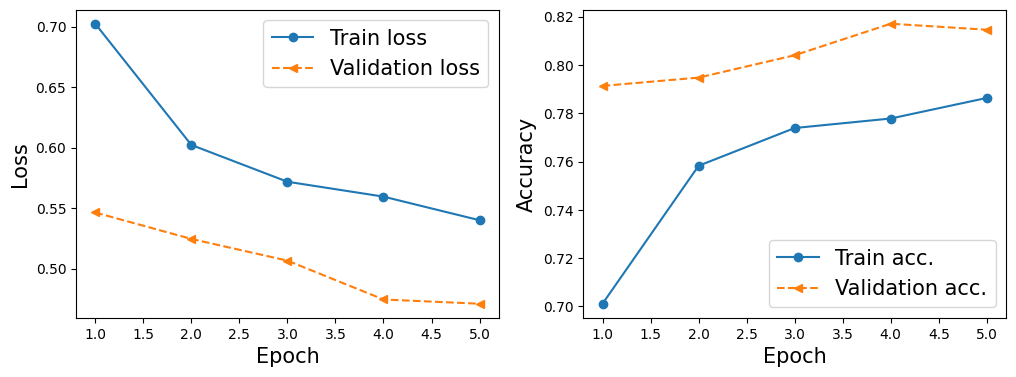

In [22]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [23]:
fc_model_eval_results = fc_model.evaluate(X_test, y_test)

MODELS["fc_model"] = {
    "model" : fc_model,
    "accuracy": fc_model_eval_results[1]
}

fc_model_eval_results

264/264 [==============================] - 1s 3ms/step - loss: 0.4908 - accuracy: 0.8047


[0.49082455039024353, 0.8047449588775635]

In [24]:
class MyFCHyperModel(kt.HyperModel):
  def build(self, hp):
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()


    hp_n_units = hp.Int('units', min_value=64, max_value = 512, step=32)
    hp_n_layers = hp.Int("layers", 2, 10, 1)



    # flattening layer
    model.add(
        tf.keras.layers.Flatten()
    )


    model.add(
        tf.keras.Input(
            shape=(64*64*n_bands)
        )
    )


    # add in hidden layers
    for i in range(hp_n_layers):
      model.add(
          tf.keras.layers.Dense(
              units=hp_n_units,
              activation="relu",
              name=f"dense_{i}_{hp_n_units}"

          )
      )

      model.add(
          tf.keras.layers.Dropout(
              rate=0.3
          )
      )

    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    model.add(tf.keras.layers.Dense(
        units=3,
        name='output',
        activation=None))






    model.build(input_shape=(None, 64, 64, n_bands))
    # model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics=['accuracy']) 

    return model

  def fit(self, hp, model, *args, **kwargs):
    # hp_batch_size = hp.Int('batch_size', min_value=64, max_value=1024, step=64)
    return model.fit(
        *args,
        **kwargs
    )



In [25]:

hp = kt.HyperParameters()

tuner = kt.Hyperband(
    MyFCHyperModel(),
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name = 'sdss_fcnn3',
)

In [26]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


In [28]:
tuner.search(X_train_subset, y_train_subset,
             validation_data=(X_val_subset, y_val_subset), callbacks=[stop_early])


Trial 30 Complete [00h 00m 14s]
val_accuracy: 0.7612826824188232

Best val_accuracy So Far: 0.7612826824188232
Total elapsed time: 00h 03m 51s


In [29]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units': 448,
 'layers': 5,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [30]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
fc_hypermodel = tuner.hypermodel.build(best_hps)
history = fc_hypermodel.fit(X_train_subset, y_train_subset, epochs=20, validation_data=(X_val_subset, y_val_subset))


# find the best # of epochs to use
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
159/159 [==============================] - 3s 7ms/step - loss: 1.4052 - accuracy: 0.3951 - val_loss: 0.9062 - val_accuracy: 0.6544
Epoch 2/20
159/159 [==============================] - 1s 6ms/step - loss: 0.9973 - accuracy: 0.4936 - val_loss: 0.8298 - val_accuracy: 0.6995
Epoch 3/20
159/159 [==============================] - 1s 6ms/step - loss: 0.9608 - accuracy: 0.5048 - val_loss: 0.7137 - val_accuracy: 0.7506
Epoch 4/20
159/159 [==============================] - 1s 6ms/step - loss: 0.9599 - accuracy: 0.5084 - val_loss: 0.7312 - val_accuracy: 0.7423
Epoch 5/20
159/159 [==============================] - 1s 6ms/step - loss: 0.9556 - accuracy: 0.5141 - val_loss: 0.7674 - val_accuracy: 0.7292
Epoch 6/20
159/159 [==============================] - 1s 6ms/step - loss: 0.9578 - accuracy: 0.5124 - val_loss: 0.7556 - val_accuracy: 0.7506
Epoch 7/20
159/159 [==============================] - 1s 6ms/step - loss: 0.9422 - accuracy: 0.5254 - val_loss: 0.7564 - val_accuracy: 0.7340
Epoch 

In [31]:
fc_hypermodel = tuner.hypermodel.build(best_hps)
print(fc_hypermodel.summary())
# Retrain the model
history = fc_hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data = (X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 dense_0_448 (Dense)         (None, 448)               9175488   
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1_448 (Dense)         (None, 448)               201152    
                                                                 
 dropout_1 (Dropout)         (None, 448)               0         
                                                                 
 dense_2_448 (Dense)         (None, 448)               2

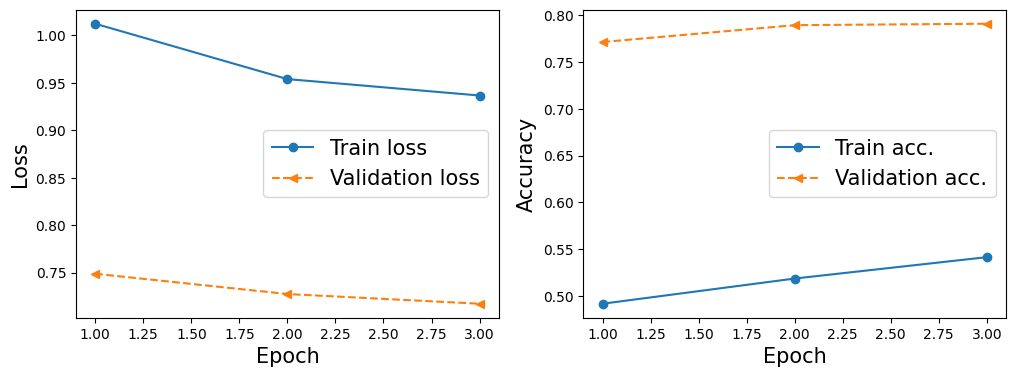

In [32]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show(   )

In [33]:
fc_hypermodel_eval_results = fc_hypermodel.evaluate(X_test, y_test)

MODELS["fc_hypermodel"] = {
    "model" : fc_hypermodel,
    "accuracy" : fc_hypermodel_eval_results[1]
}

fc_hypermodel_eval_results

264/264 [==============================] - 1s 3ms/step - loss: 0.7243 - accuracy: 0.7836


[0.7243302464485168, 0.7836298942565918]

### Convolutional Neural Network

In [34]:
tf.keras.backend.clear_session()
cnn_model = models.Sequential()

# add first convolution layer to the model
cnn_model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
cnn_model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add first convolution layer to the model
cnn_model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_2',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
cnn_model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_2'))




# add a fully connected layer (need to flatten the output of the previous layers first)
cnn_model.add(tf.keras.layers.Flatten()) 
cnn_model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
cnn_model.add(tf.keras.layers.Dropout(
    rate=0.5))



cnn_model.add(tf.keras.layers.Dense(
    units=3,
    name='fc_2',
    activation=None))



tf.random.set_seed(1)
cnn_model.build(input_shape=(None, 64, 64, n_bands))
cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 32)        4032      
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 fc_1 (Dense)                (None, 1024)              16778240  
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [35]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

In [36]:
tf.random.set_seed(1234)
np.random.seed(1234)
history = cnn_model.fit(X_train, y_train,
                    epochs=5, 
                    validation_data=(X_val, y_val)
)

Epoch 1/5
1581/1581 [==============================] - 16s 6ms/step - loss: 0.6308 - accuracy: 0.7500 - val_loss: 0.5069 - val_accuracy: 0.8040
Epoch 2/5
1581/1581 [==============================] - 8s 5ms/step - loss: 0.5377 - accuracy: 0.7911 - val_loss: 0.4851 - val_accuracy: 0.8155
Epoch 3/5
1581/1581 [==============================] - 8s 5ms/step - loss: 0.5050 - accuracy: 0.8048 - val_loss: 0.4882 - val_accuracy: 0.8130
Epoch 4/5
1581/1581 [==============================] - 8s 5ms/step - loss: 0.4824 - accuracy: 0.8114 - val_loss: 0.4859 - val_accuracy: 0.8134
Epoch 5/5
1581/1581 [==============================] - 8s 5ms/step - loss: 0.4552 - accuracy: 0.8223 - val_loss: 0.5262 - val_accuracy: 0.8084


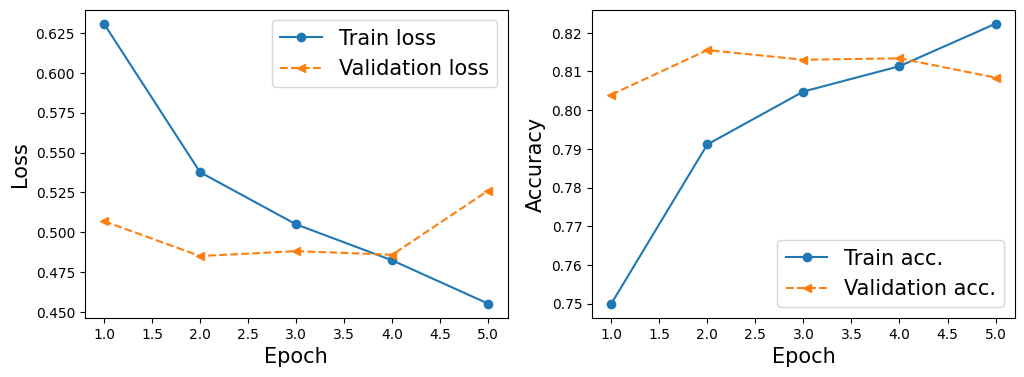

In [37]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [38]:
cnn_model_eval_results = cnn_model.evaluate(X_test, y_test)

MODELS["cnn_model"] = {
    "model" : cnn_model,
    "accuracy" : cnn_model_eval_results[1]
}
cnn_model_eval_results

264/264 [==============================] - 1s 3ms/step - loss: 0.5337 - accuracy: 0.7972


[0.5337047576904297, 0.7971529960632324]

In [39]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()


    # tune the number of filters to use in the first conv layer
    hp_filters = hp.Int('filters', min_value=32, max_value = 128, step=8)
    hp_n_layers = hp.Int("layers", 2, 5,)
    # hp_kernel_size = hp.Int('filters_size', min_value=2, max_value=10, step=1)
    # hp_strides_size = hp.Int("strides_size", min_value=1, max_value=5, step=1)
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])


    for i in range(hp_n_layers):
      model.add(
          tf.keras.layers.Conv2D(
              filters=hp_filters,
              kernel_size=(5, 5),
              strides=(1, 1),
              padding='same',
              data_format="channels_last",
              name=f"conv_{i}",
              activation='relu'
          )
      )

      model.add(
          tf.keras.layers.MaxPool2D(
              pool_size = (2,2),
              name=f"pool_{i}"
          )
      )


    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=2048,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    model.add(tf.keras.layers.Dense(
        units=3,
        name='fc_2',
        activation=None))






    model.build(input_shape=(None, 64, 64, n_bands))
    # model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics=['accuracy']) 

    return model

  def fit(self, hp, model, *args, **kwargs):
    # hp_batch_size = hp.Int('batch_size', min_value=64, max_value=1024, step=64)
    return model.fit(
        *args,
        **kwargs
    )



In [40]:

hp = kt.HyperParameters()

tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name = 'sdss_cnn2',
)






# model = create_model()
# tf.keras.KerasClassifier()
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
#               metrics=['accuracy']) 


In [41]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [42]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 8, 'sampling': 'linear'}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}


In [43]:
tuner.search(X_train_subset, y_train_subset,
             validation_data=(X_val_subset, y_val_subset), callbacks=[stop_early])




Trial 30 Complete [00h 00m 19s]
val_accuracy: 0.7577196955680847

Best val_accuracy So Far: 0.786223292350769
Total elapsed time: 00h 04m 08s


In [44]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'filters': 40,
 'layers': 5,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [45]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
cnn_hypermodel = tuner.hypermodel.build(best_hps)
history = cnn_hypermodel.fit(X_train_subset, y_train_subset, epochs=20, validation_data=(X_val_subset, y_val_subset))

# find the best # of epochs to use
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
159/159 [==============================] - 4s 8ms/step - loss: 0.8321 - accuracy: 0.5950 - val_loss: 0.6761 - val_accuracy: 0.7458
Epoch 2/20
159/159 [==============================] - 1s 7ms/step - loss: 0.6623 - accuracy: 0.7330 - val_loss: 0.6287 - val_accuracy: 0.7435
Epoch 3/20
159/159 [==============================] - 1s 8ms/step - loss: 0.5952 - accuracy: 0.7649 - val_loss: 0.6434 - val_accuracy: 0.7375
Epoch 4/20
159/159 [==============================] - 1s 8ms/step - loss: 0.5572 - accuracy: 0.7797 - val_loss: 0.6086 - val_accuracy: 0.7708
Epoch 5/20
159/159 [==============================] - 1s 8ms/step - loss: 0.5469 - accuracy: 0.7872 - val_loss: 0.5887 - val_accuracy: 0.7815
Epoch 6/20
159/159 [==============================] - 1s 8ms/step - loss: 0.5446 - accuracy: 0.7870 - val_loss: 0.5558 - val_accuracy: 0.7720
Epoch 7/20
159/159 [==============================] - 1s 7ms/step - loss: 0.5512 - accuracy: 0.7829 - val_loss: 0.6944 - val_accuracy: 0.6948
Epoch 

In [46]:
cnn_hypermodel = tuner.hypermodel.build(best_hps)
print(cnn_hypermodel.summary())

# Retrain the model
history = cnn_hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data = (X_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv2D)             (None, 64, 64, 40)        5040      
                                                                 
 pool_0 (MaxPooling2D)       (None, 32, 32, 40)        0         
                                                                 
 conv_1 (Conv2D)             (None, 32, 32, 40)        40040     
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 16, 40)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 40)        40040     
                                                                 
 pool_2 (MaxPooling2D)       (None, 8, 8, 40)          0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 40)          4

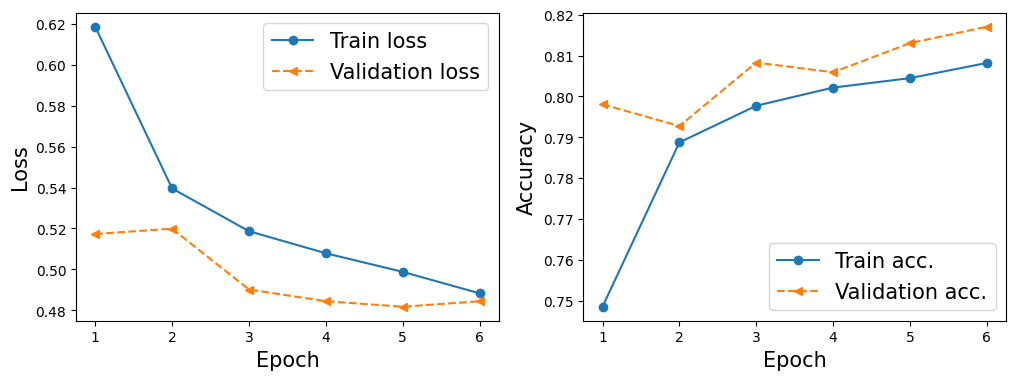

In [47]:
import matplotlib.pyplot as plt
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show(   )

In [48]:
cnn_hypermodel_eval_results = cnn_hypermodel.evaluate(X_test, y_test)
MODELS["cnn_hypermodel"] = {
    "model" : cnn_hypermodel,
    "accuracy" : cnn_hypermodel_eval_results[1]
}
cnn_hypermodel_eval_results

264/264 [==============================] - 1s 4ms/step - loss: 0.4990 - accuracy: 0.8057


[0.49895110726356506, 0.8056939244270325]

## Applying to an entire image (for fun)

In [49]:
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.visualization import ZScaleInterval, SinhStretch, ImageNormalize


def get_img_plate(row):
    row = row.squeeze()
    bands = ['u', 'g', 'r', 'i', 'z']
    run_id = row['run_ID']
    rerun_id = row['rerun_ID']
    cam_col = row['cam_col']
    field_id = row['field_ID']

    ra = Angle(row['alpha'], u.deg)
    dec = Angle(row['delta'], u.deg)
    c = SkyCoord(ra, dec, frame='icrs')

    xids_table = SDSS.query_region(c)


    xids_table = SDSS.query_region(c) # this can return multiple items
    xids = xids_table.to_pandas()
    xids = xids.query(f"run == {run_id} and rerun == {rerun_id} and camcol == {cam_col} and field == {field_id}")
    xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)
    best_plate = xids[xids['distance_from_object'] == xids['distance_from_object'].min()]

    best_plate = Table.from_pandas(best_plate.drop("distance_from_object", axis=1))
    img_data_buffer = [SDSS.get_images(matches=best_plate, band = band) for band in bands]


    return img_data_buffer

In [50]:
df = pd.read_csv(data_dir / "star_classification.csv")


In [51]:
def scale_img(img_data):

  # scale the image so its viewable
  interval = ZScaleInterval(max_iterations=10)
  vmin, vmax = interval.get_limits(img_data)
  norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch(), clip=True)
  img_data = norm(img_data)

  return img_data



# lets try the above model on a full frame and see what it classifies

rand_idx = np.random.randint(0, len(df), 1)
# rand_idx = 26688
# rand_idx = 63658
# rand_idx = 45757
# rand_idx = 11586


# get a full frame
img_data_buffer = get_img_plate(df.iloc[rand_idx])
img_data_buffer = [scale_img(img_data[0][0].data) for img_data in img_data_buffer]


# pick a band
rand_band_idx = np.random.randint(0, n_bands, 1)[0]
rand_band_idx = 2

img_data = img_data_buffer[rand_band_idx]







<ipython-input-49-5959460db7f5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)


In [52]:
print([img_data.min() for img_data in img_data_buffer])
print([img_data.max() for img_data in img_data_buffer])

[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0]


[92975]
2


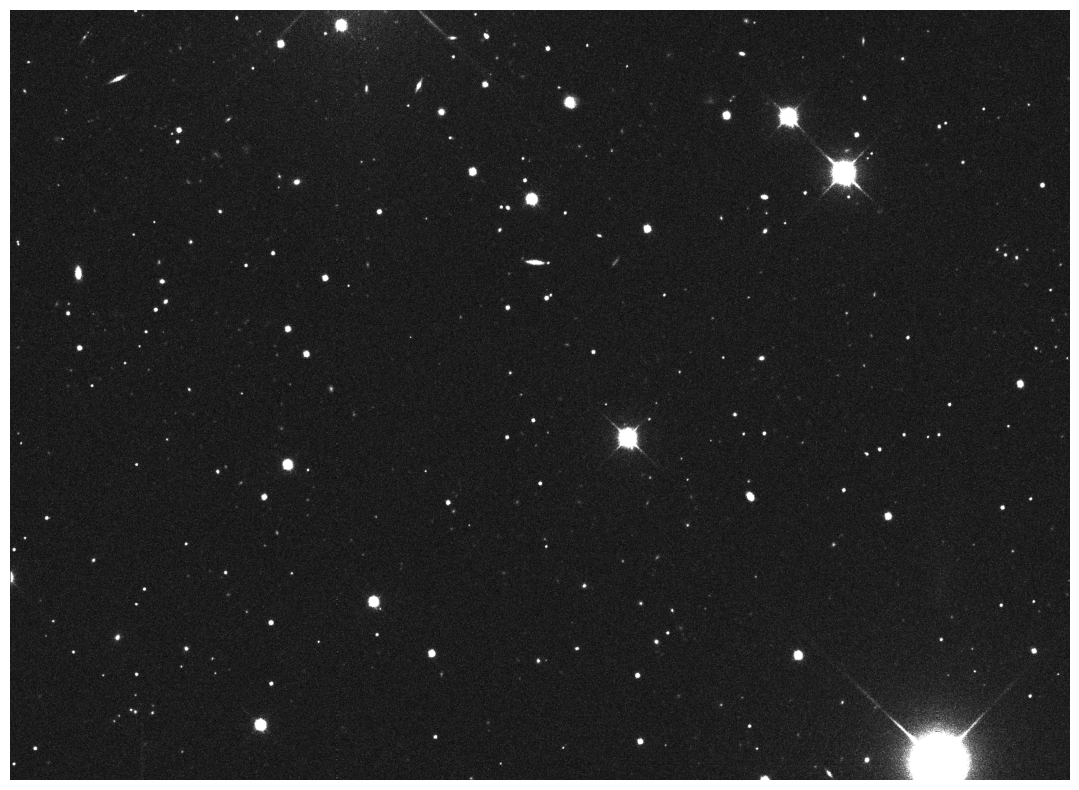

In [53]:
print(rand_idx)
print(rand_band_idx)
plt.figure(figsize=(16,10))
plt.imshow(img_data, cmap="gray")
plt.axis("off")
plt.savefig(output_imgs_dir/f"normalized_example_image_{rand_idx}.png", dpi=1000, bbox_inches='tight', transparent=True)

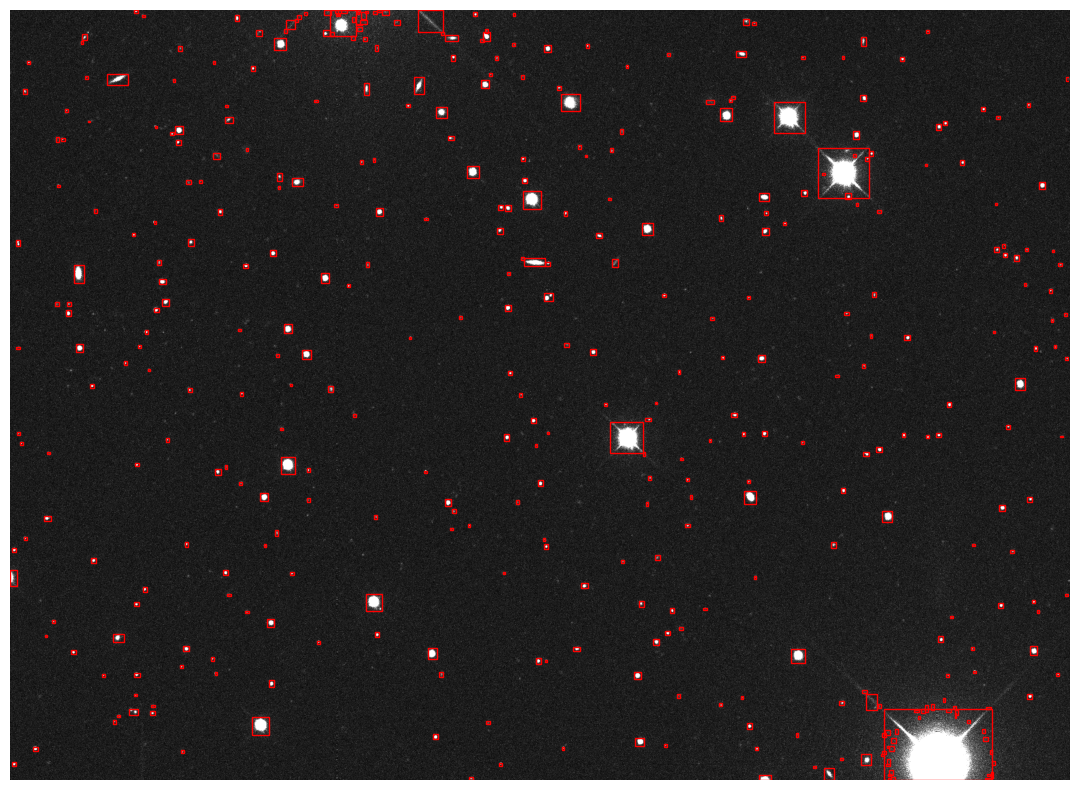

In [54]:
from photutils.detection import find_peaks
from photutils.segmentation import detect_sources, detect_threshold, SourceFinder, SourceCatalog

# find some peaks
threshold = detect_threshold(img_data, nsigma=3)
source_map = detect_sources(img_data, npixels=10, threshold=threshold)

red_sources = SourceCatalog(data=img_data, segment_img=source_map)


from matplotlib import patches
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,10)
ax.imshow(img_data, cmap="gray")
ax.axis("off")

for bbox in red_sources.bbox:
  rect = patches.Rectangle(xy=(bbox.ixmin, bbox.iymin), width=(bbox.ixmax - bbox.ixmin), height=(bbox.iymax - bbox.iymin), edgecolor='red', fill=False)
  ax.add_patch(rect)

fig.savefig(output_imgs_dir/f"normalized_example_image_bboxes_{rand_idx}.png", dpi=1000, bbox_inches='tight', transparent=True)

In [55]:
all_bands_img_data = np.ndarray(shape=(img_data.shape[0], img_data.shape[1], len(img_data_buffer)))
all_bands_sources = []

for idx, band_data in enumerate(img_data_buffer):
  band_img_data = band_data
  all_bands_img_data[:,:,idx] = band_img_data

  threshold = detect_threshold(band_img_data, nsigma=3)
  source_map = detect_sources(band_img_data, npixels=10, threshold=threshold)
  sources = SourceCatalog(data=band_img_data, segment_img=source_map)
  all_bands_sources.append(sources)




In [56]:
# find the band with the most sources and use that one to generate image chips to feed into model
n_sources_per_band = np.array([len(sources)  for sources in all_bands_sources])
best_band_idx = np.argmax(n_sources_per_band)
best_band_data = all_bands_sources[best_band_idx]
print(len(best_band_data))
print(best_band_idx)


447
3


In [57]:
all_frame_sources = np.ndarray(shape=(len(best_band_data), 64, 64, n_bands))

for iobject in range(len(best_band_data)):
  ixmin, ixmax, iymin, iymax = best_band_data[iobject].bbox.ixmin, best_band_data[iobject].bbox.ixmax, best_band_data[iobject].bbox.iymin, best_band_data[iobject].bbox.iymax

  object_data = np.ndarray(shape=(64, 64, n_bands))

  for iband in range(n_bands):
    chip_band_data = all_bands_img_data[:,:,iband]
    chip_data = all_bands_img_data[iymin:iymax, ixmin:ixmax, iband]
    # resize to 64x64 to be put into tf model
    chip_data = np.expand_dims(chip_data, axis=2)
    chip_data = tf.image.resize_with_pad(chip_data, target_height=64, target_width=64)
    chip_data = np.reshape(chip_data, (64,64))
    chip_data = scale_img(chip_data)
    object_data[:,:,iband] = chip_data
    
  all_frame_sources[iobject] = object_data



/usr/local/lib/python3.9/dist-packages/astropy/visualization/mpl_normalize.py:180: RuntimeWarning: divide by zero encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/usr/local/lib/python3.9/dist-packages/astropy/visualization/mpl_normalize.py:180: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


In [58]:
all_frame_sources.shape

(447, 64, 64, 5)

In [59]:
test_results_df = pd.DataFrame.from_dict(MODELS).T
test_results_df

,model,accuracy
fc_model,<keras.engine.sequential.Sequential object at ...,0.804745
fc_hypermodel,<keras.engine.sequential.Sequential object at ...,0.78363
cnn_model,<keras.engine.sequential.Sequential object at ...,0.797153
cnn_hypermodel,<keras.engine.sequential.Sequential object at ...,0.805694


In [60]:
best_model = test_results_df[test_results_df['accuracy'] == test_results_df['accuracy'].max()]
best_model

,model,accuracy
cnn_hypermodel,<keras.engine.sequential.Sequential object at ...,0.805694


In [61]:
best_model_name = best_model.index.tolist()[0]
best_model_obj = best_model['model'].values[0]
object_prediction_logits = best_model_obj.predict(all_frame_sources)
object_probas = tf.sigmoid(object_prediction_logits)


14/14 [==============================] - 0s 12ms/step


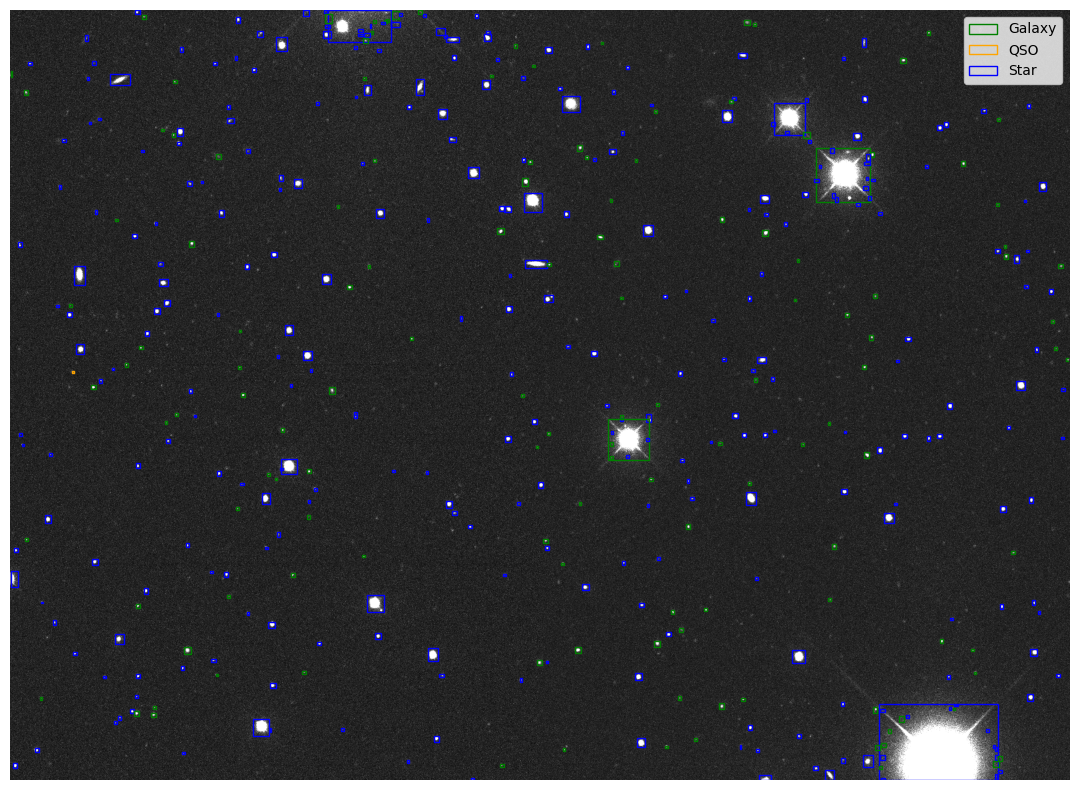

In [62]:
# plot the boxes again
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,10)


ax.imshow(img_data_buffer[best_band_idx], cmap="gray")
ax.axis("off")

for idx, bbox in enumerate(best_band_data.bbox):
  obj_class = np.argmax(object_probas[idx])

  if obj_class == 0: # galaxy
    color = 'green'
    label = "Galaxy"
  elif obj_class == 1: # QSO
    color = 'orange'
    label = "QSO"
  elif obj_class == 2: # star
    color = 'blue'
    label = "Star"
  else:
    color = 'red'
    label = "Unknown"


  rect = patches.Rectangle(xy=(bbox.ixmin, bbox.iymin), width=(bbox.ixmax - bbox.ixmin), height=(bbox.iymax - bbox.iymin), edgecolor=color, fill=False)
  ax.add_patch(rect)


legend_elements = [
    patches.Rectangle(xy=[0,0], width=1, height=1,color='green', label="Galaxy", fill=False),
    patches.Rectangle(xy=[0,0], width=1, height=1,color='orange', label="QSO", fill=False),
    patches.Rectangle(xy=[0,0], width=1, height=1,color='blue', label='Star', fill=False),
]
ax.legend(handles = legend_elements, loc='upper right')


In [63]:
fig.savefig(output_imgs_dir/f"normalized_example_image_bboxes_classified_{rand_idx}_{best_model_name}.png", dpi=1000, bbox_inches='tight', transparent=True)
# fig.savefig(output_imgs_dir/f"normalized_example_image_bboxes_classified_{rand_idx}.png", dpi=1000, bbox_inches='tight', transparent=True)

In [64]:
all_frame_sources[2,:,:].max()

1.0